In [52]:
# 필요한 모듈 설정하기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 시각화 위한 모듈 설정하기
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('얍💢')

얍💢


In [53]:
# 데이터 불러오기
import os
from os.path import join

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [54]:
# 데이터 살펴보기
train.head() 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [55]:
# 타겟 데이터인 price를 y에서 지우기
X = train.drop(columns=['price', 'id'])
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [56]:
# train 데이터 전처리 -> 의미 없는 id 데이터 train에서 지우기
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [57]:
# test 데이터 전처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


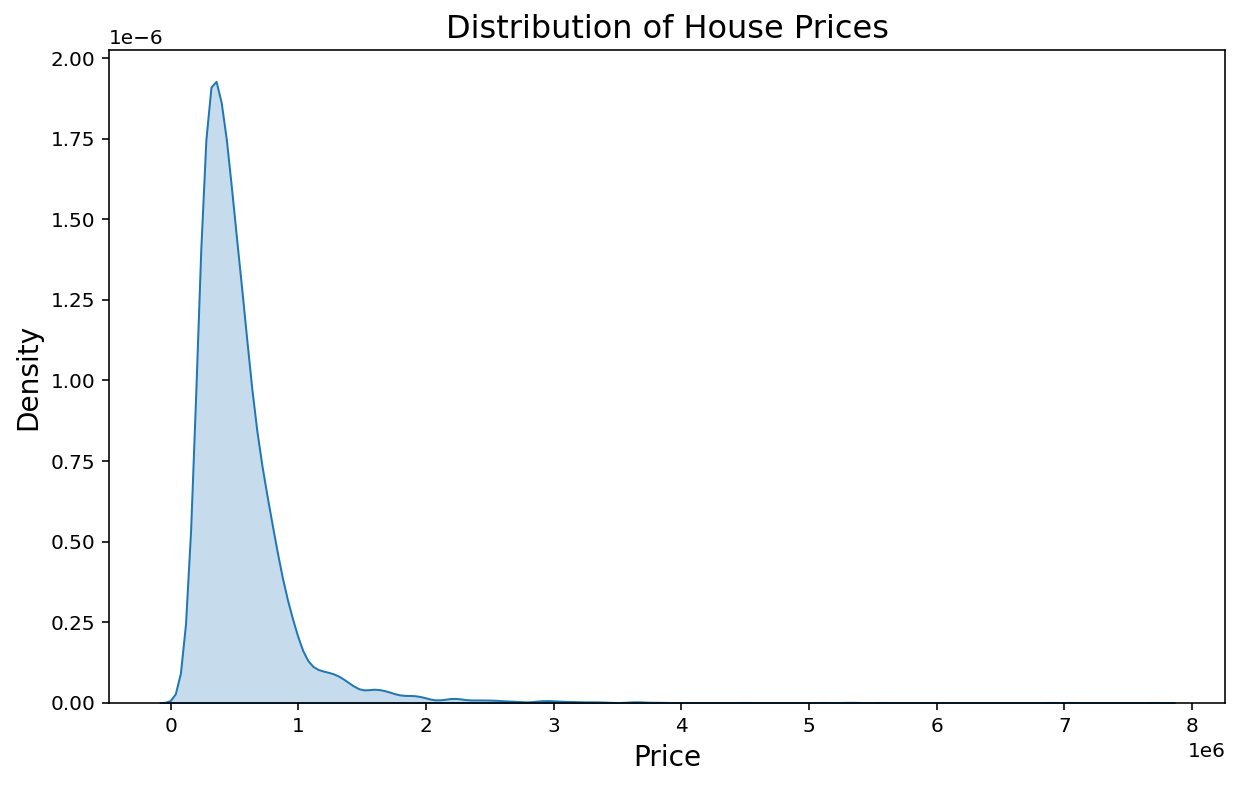

In [58]:
# price 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

# 예를 들어 y는 pandas Series로 제공되는 가격 데이터라고 가정합니다.
# y = pd.Series([...])  # 예시로 실제 데이터로 대체해야 합니다.

# KDE 플롯 생성
plt.figure(figsize=(10, 6))  # 그래프의 크기를 설정합니다.
sns.kdeplot(y, fill=True)  # y의 KDE 플롯을 그립니다. fill=True는 영역을 색칠합니다.

# 그래프 제목 및 레이블 설정
plt.title('Distribution of House Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Density', fontsize=14)

# 그래프 표시
plt.show()


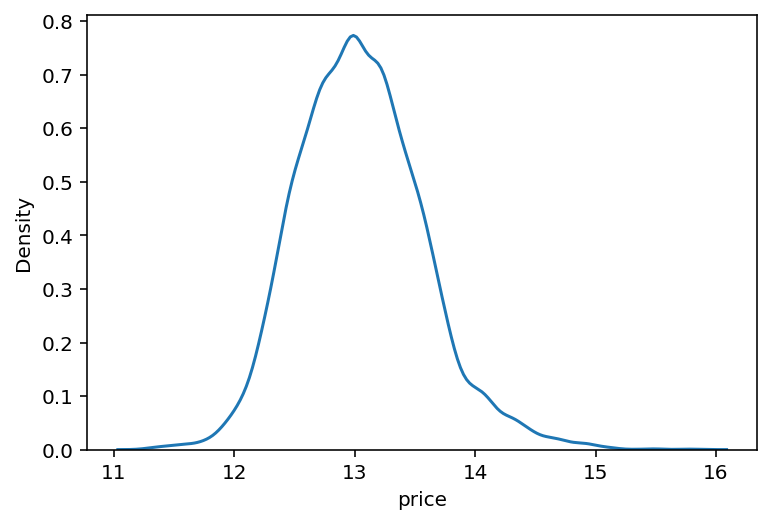

In [59]:
# log 취해서 정규분포화 시키기
y = np.log1p(y)
y
# 다시 그래프 시각화
sns.kdeplot(y)
plt.show()

In [60]:
# 전체 데이터 자료형 파악
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  object 
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [61]:
# RMSE 계산

# RMSE 계산 위한 라이브러리 가져오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE 함수 생성
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 모델 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor



In [62]:
# 랜덤 시드값 2020으로 고정하기
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택 
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [63]:
# 모델 이름 얻기
gboost.__class__.__name__

'GradientBoostingRegressor'

In [64]:
# 모델 별로 RMSE 값을 도출하는 함수 만들기
def get_scores(models, X, y):
    results = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(
            train, y,
            test_size=0.2,
            random_state=42
        )

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 RMSE 값 저장
        results[model_name] = rmse(y_test, y_pred)
    
    # 결과를 DataFrame으로 변환하고 RMSE 값으로 정렬
    score_df = pd.DataFrame(results, index=['RMSE']).T.sort_values('RMSE', ascending=True)

    return score_df

In [68]:
# 하이퍼 파라미터로 실험하기

# 실험에 필요한 라이브러리 및 클래스 사용
from sklearn.model_selection import GridSearchCV

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [50, 100, 150],                # 사용될 모델의 개수
    'max_depth': [3, 6, 10],                       # 의사 결정 나무의 최대 깊이
    'learning_rate': [0.01, 0.1, 0.2],             # 학습률
    'num_leaves': [31, 63, 127],                   # 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
    'boosting_type': ['gbdt', 'dart'],             # 부스팅 방식 (LightGBM에서 사용)                                           
}


In [69]:
# 사용할 모델 선정. 1. LGBM
model = LGBMRegressor(random_state=random_state)


In [70]:
# model, param_grid와 함께 여러 가지 인자를 넣어서 GridSearchCV를 수행
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(X, y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: date

In [ ]:
# 실험 결과 저장
grid_model.cv_results_